# Overview
This is kernel is almost the same as [Lightweight Roberta solution in PyTorch](https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch), but instead of "roberta-base", it starts from [Maunish's pre-trained model](https://www.kaggle.com/maunish/clrp-roberta-base).

Acknowledgments: some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [1]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup
from torch import optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import gc
gc.enable()

In [2]:
NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 256
EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
ROBERTA_PATH = "../input/clrp-roberta-base/clrp_roberta_base"
TOKENIZER_PATH = "../input/clrp-roberta-base/clrp_roberta_base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

In [3]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True
    
set_random_seed(SEED)    


In [4]:
# train_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/train.csv")

test_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
submission_df = pd.read_csv("/kaggle/input/commonlitreadabilityprize/sample_submission.csv")
folds_df = pd.read_csv('../input/train-val-split/kfold.csv')

In [5]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [6]:
def convert_examples_to_features(text, tokenizer, max_len):
    tok = tokenizer.encode_plus(
        text, 
        max_length=max_len, 
        truncation=True,
        padding='max_length',
    )
    return tok

class CLRPDataset(Dataset):
    def __init__(self, data, tokenizer, is_test=False):
        self.data = data
        self.excerpts = self.data.excerpt.tolist()
        if not is_test:
            self.targets = self.data.target.tolist()
            
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        if not self.is_test:

            excerpt = self.excerpts[item]
            label = self.targets[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                'label':torch.tensor(label, dtype=torch.float),
            }
        else:
            excerpt = self.excerpts[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            }

# Model
The model is inspired by the one from [Maunish](https://www.kaggle.com/maunish/clrp-roberta-svm).

In [7]:
class AttentionHead(nn.Module):
    def __init__(self, hidden_dim=512):
        super().__init__()
        self.W = nn.Linear(768, 512)
        self.V = nn.Linear(512, 1)
        
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

class CLRPModel(nn.Module):
    def __init__(self,transformer,config):
        super(CLRPModel,self).__init__()
        self.h_size = config.hidden_size
        self.transformer = transformer
        self.head = AttentionHead(self.h_size)
        self.linear = nn.Linear(self.h_size, 1)
              
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer(input_ids, attention_mask)
        x = self.head(transformer_out.last_hidden_state)
        x = self.linear(x)
        return x

    
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:197]    
    attention_parameters = named_parameters[199:203]
    regressor_parameters = named_parameters[203:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 2e-5

        if layer_num >= 69:        
            lr = 5e-5

        if layer_num >= 133:
            lr = 1e-4

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return optim.AdamW(parameters)

In [8]:
def eval_mse(model, data_loader):
    model.eval()            
    mse_sum = 0

    with torch.no_grad():
        for batch_num, batch in enumerate(data_loader):
            input_ids, attention_mask, target = batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE), batch['label'].to(DEVICE)

            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)                        
            target = target.to(DEVICE)           
            
            pred = model(input_ids, attention_mask)                       

            mse_sum += nn.MSELoss(reduction="sum")(pred.flatten(), target).item()
                

    return mse_sum / len(data_loader.dataset)

In [9]:
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, batch in enumerate(data_loader):
            input_ids, attention_mask = batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE)

            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result

In [10]:
def rmse_loss(y_true,y_pred):
    return torch.sqrt(nn.functional.mse_loss(y_true,y_pred))


In [11]:
def train(model, model_path, train_loader, val_loader,
          optimizer, scheduler=None, num_epochs=NUM_EPOCHS):    
    best_val_rmse = None
    best_epoch = 0
    step = 0
    last_eval_step = 0
    eval_period = EVAL_SCHEDULE[0][1]    

    start = time.time()
    losses_info = {
        'train_loss': [],
        'val_loss': [],
    }
    for epoch in range(num_epochs):                           
        val_rmse = None         

        for batch_num, batch in enumerate(train_loader):
            model.train()
            
            input_ids, attention_mask, target = batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE), batch['label'].to(DEVICE)
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)            
            target = target.to(DEVICE)                        

            optimizer.zero_grad()
            

            pred = model(input_ids, attention_mask)
                                                        
#             mse = nn.MSELoss(reduction="mean")(pred.flatten(), target)
            mse = rmse_loss(pred, target.unsqueeze(1))
#             print(f'{epoch+1}#[{step+1}/{len(train_loader)}]: train loss - {mse.item()}')

            mse.backward()
            losses_info['train_loss'].append((step, math.sqrt(mse)))
            
            optimizer.step()
#             if scheduler:
            scheduler.step()
            
            if step >= last_eval_step + eval_period:
                # Evaluate the model on val_loader.
                elapsed_seconds = time.time() - start
                num_steps = step - last_eval_step
                print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                last_eval_step = step
                
                val_rmse = math.sqrt(eval_mse(model, val_loader))                            
                losses_info['val_loss'].append((step, val_rmse))

                print(f"Epoch: {epoch} batch_num: {batch_num}", 
                      f"val_rmse: {val_rmse:0.4}")

                for rmse, period in EVAL_SCHEDULE:
                    if val_rmse >= rmse:
                        eval_period = period
                        break                               
                
                if not best_val_rmse or val_rmse < best_val_rmse:                    
                    best_val_rmse = val_rmse
                    best_epoch = epoch
#                     torch.save(model.state_dict(), model_path)
                    torch.save(model, model_path)
                    print(f"New best_val_rmse: {best_val_rmse:0.4}")
                else:       
                    print(f"Still best_val_rmse: {best_val_rmse:0.4}",
                          f"(from epoch {best_epoch})")                                    
                    
                start = time.time()
                                            
            step += 1
                        
    
    return best_val_rmse, losses_info


Fold 1/5


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 8.21 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.014
New best_val_rmse: 1.014

16 steps took 6.78 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.6904
New best_val_rmse: 0.6904

16 steps took 6.72 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.6516
New best_val_rmse: 0.6516

16 steps took 6.76 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.7135
Still best_val_rmse: 0.6516 (from epoch 0)

16 steps took 6.77 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.5489
New best_val_rmse: 0.5489

16 steps took 6.66 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.5237
New best_val_rmse: 0.5237

16 steps took 6.7 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6196
Still best_val_rmse: 0.5237 (from epoch 0)

16 steps took 6.63 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.5164
New best_val_rmse: 0.5164

16 steps took 6.91 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.5156
New best_val_rmse: 0.5156

16 steps took 6.76 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.5224
Still best_val_rmse: 0.5156 (from epoch 1)

16 steps t

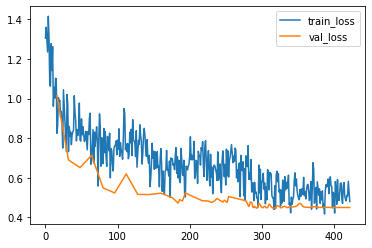


Performance estimates:
[0.44652368723097874]
Mean: 0.44652368723097874

Fold 2/5


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 7.26 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.9114
New best_val_rmse: 0.9114

16 steps took 6.68 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.7678
New best_val_rmse: 0.7678

16 steps took 6.68 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.6795
New best_val_rmse: 0.6795

16 steps took 6.72 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.5855
New best_val_rmse: 0.5855

16 steps took 6.75 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.5877
Still best_val_rmse: 0.5855 (from epoch 0)

16 steps took 6.7 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.753
Still best_val_rmse: 0.5855 (from epoch 0)

16 steps took 6.67 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7162
Still best_val_rmse: 0.5855 (from epoch 0)

16 steps took 6.68 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.5257
New best_val_rmse: 0.5257

16 steps took 6.9 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.5757
Still best_val_rmse: 0.5257 (from epoch 0)

16 steps took 6.73 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.5378
Still best_val_rmse:

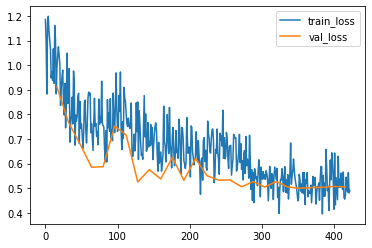


Performance estimates:
[0.44652368723097874, 0.5002135442269238]
Mean: 0.4733686157289513

Fold 3/5


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 7.33 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.9945
New best_val_rmse: 0.9945

16 steps took 6.66 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.697
New best_val_rmse: 0.697

16 steps took 6.75 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.6913
New best_val_rmse: 0.6913

16 steps took 6.9 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6005
New best_val_rmse: 0.6005

16 steps took 6.8 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.578
New best_val_rmse: 0.578

16 steps took 6.79 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.7018
Still best_val_rmse: 0.578 (from epoch 0)

16 steps took 6.68 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.5941
Still best_val_rmse: 0.578 (from epoch 0)

16 steps took 6.72 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6061
Still best_val_rmse: 0.578 (from epoch 0)

16 steps took 6.89 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.5322
New best_val_rmse: 0.5322

16 steps took 6.69 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.6146
Still best_val_rmse: 0.5322 (from epoch 1)


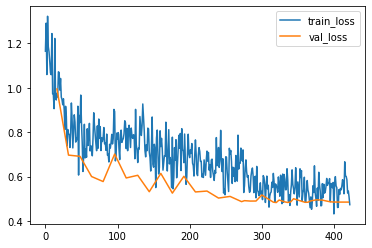


Performance estimates:
[0.44652368723097874, 0.5002135442269238, 0.4833453906642777]
Mean: 0.4766942073740601

Fold 4/5


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 7.35 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.9362
New best_val_rmse: 0.9362

16 steps took 6.78 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.6954
New best_val_rmse: 0.6954

16 steps took 6.79 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.7509
Still best_val_rmse: 0.6954 (from epoch 0)

16 steps took 6.71 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6373
New best_val_rmse: 0.6373

16 steps took 6.76 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6481
Still best_val_rmse: 0.6373 (from epoch 0)

16 steps took 6.76 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.654
Still best_val_rmse: 0.6373 (from epoch 0)

16 steps took 6.65 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.5956
New best_val_rmse: 0.5956

16 steps took 6.7 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6362
Still best_val_rmse: 0.5956 (from epoch 0)

16 steps took 6.95 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.556
New best_val_rmse: 0.556

16 steps took 6.82 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.6106
Still best_val_rmse: 

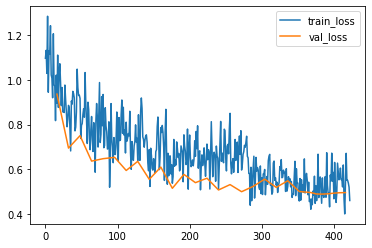


Performance estimates:
[0.44652368723097874, 0.5002135442269238, 0.4833453906642777, 0.4900945568616675]
Mean: 0.48004429474596194

Fold 5/5


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



16 steps took 7.29 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.083
New best_val_rmse: 1.083

16 steps took 6.78 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.7591
New best_val_rmse: 0.7591

16 steps took 6.67 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.9547
Still best_val_rmse: 0.7591 (from epoch 0)

16 steps took 6.64 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.7033
New best_val_rmse: 0.7033

16 steps took 6.68 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.596
New best_val_rmse: 0.596

16 steps took 6.81 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.5528
New best_val_rmse: 0.5528

16 steps took 6.85 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6287
Still best_val_rmse: 0.5528 (from epoch 0)

16 steps took 6.69 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.5447
New best_val_rmse: 0.5447

16 steps took 6.88 seconds
Epoch: 1 batch_num: 3 val_rmse: 0.5386
New best_val_rmse: 0.5386

16 steps took 6.72 seconds
Epoch: 1 batch_num: 19 val_rmse: 0.5164
New best_val_rmse: 0.5164

16 steps took 6.76 seconds
E

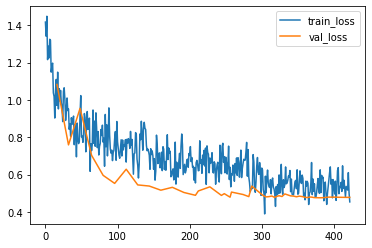


Performance estimates:
[0.44652368723097874, 0.5002135442269238, 0.4833453906642777, 0.4900945568616675, 0.4758608109911871]
Mean: 0.479207597995007


In [12]:
gc.collect()

list_val_rmse = []

for fold in range(5):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")
    model_path = f"model_{fold + 1}.pth"
        
#     set_random_seed(SEED + fold)
    train_dataset = CLRPDataset(folds_df[folds_df.fold!=fold], tokenizer=tokenizer)    
    val_dataset = CLRPDataset(folds_df[folds_df.fold==fold], tokenizer=tokenizer) 
  
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              drop_last=True, shuffle=True, num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=2)    
        
#     set_random_seed(SEED + fold)    
    
    config = AutoConfig.from_pretrained(ROBERTA_PATH)
    config.update({
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7
            }) 

    transformer = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
    
    model = CLRPModel(transformer, config).to(DEVICE)
    
    optimizer = create_optimizer(model)                        
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_training_steps=NUM_EPOCHS * len(train_loader),
        num_warmup_steps=50)    
    
    val_rmse, losses_info = train(model, model_path, train_loader,
                               val_loader, optimizer, scheduler=scheduler)
    list_val_rmse.append(val_rmse)

    del model
    gc.collect()
    
    
    steps, train_losses = list(zip(*losses_info['train_loss']))
    plt.plot(steps, train_losses, label='train_loss')
    steps, val_losses = list(zip(*losses_info['val_loss']))
    plt.plot(steps, val_losses, label='val_loss')
    plt.legend()
    plt.show()
    
    print("\nPerformance estimates:")
    print(list_val_rmse)
    print("Mean:", np.array(list_val_rmse).mean())
    

# Inference

In [13]:
all_predictions = np.zeros((5, len(test_df)))

test_dataset = CLRPDataset(test_df, tokenizer, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         drop_last=False, shuffle=False, num_workers=2)
for index in range(5):            
    model_path = f"./model_{index+1}.pth"
    print(f"\nUsing {model_path}")
#     transformer = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
     
#     model = CLRPModel(transformer, config)
#     model.load_state_dict(torch.load(model_path))    
    model = torch.load(f'./model_{index+1}.pth')
    model.to(DEVICE)
#     torch.save(model, f'model_full_{index}.pth')
    
    all_predictions[index] = predict(model, test_loader)
    torch.save(model, f'model_{index+1}.pth')
    del model
    gc.collect()


Using ./model_1.pth

Using ./model_2.pth

Using ./model_3.pth

Using ./model_4.pth

Using ./model_5.pth


In [14]:
print(all_predictions)
predictions = all_predictions.mean(axis=0)
submission_df.target = predictions
print(submission_df)
submission_df.to_csv("submission.csv", index=False)

[[-5.01732171e-01 -7.90308714e-01 -3.44195276e-01 -2.51343036e+00
  -1.76394796e+00 -1.41955435e+00 -1.08137261e-03]
 [-3.02523404e-01 -4.77962285e-01 -3.28100532e-01 -2.32186532e+00
  -1.61834049e+00 -1.54626155e+00  3.10083240e-01]
 [-3.23021919e-01 -5.61194062e-01 -4.21046257e-01 -2.66681433e+00
  -1.83380675e+00 -1.44253719e+00 -9.96758565e-02]
 [-4.94369119e-01 -5.05361974e-01 -3.67678016e-01 -2.36705184e+00
  -1.75247717e+00 -1.41491306e+00  2.49948204e-02]
 [-5.24717450e-01 -6.75353050e-01 -2.37845808e-01 -2.42250228e+00
  -1.63640022e+00 -1.47660983e+00  2.89626807e-01]]
          id    target
0  c0f722661 -0.429273
1  f0953f0a5 -0.602036
2  0df072751 -0.339773
3  04caf4e0c -2.458333
4  0e63f8bea -1.720995
5  12537fe78 -1.459975
6  965e592c0  0.104790


In [15]:
folds_df[folds_df.fold==4].head()

,id,url_legal,license,excerpt,target,standard_error,bins,fold
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,4
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,4
10,c57b50918,NaN,NaN,It was believed by the principal men of Virgin...,-3.081337,0.553260,1,4
23,66f0a9ff1,NaN,NaN,If nature afflicts in one direction she freque...,-2.386485,0.526079,2,4
33,83e4f4031,NaN,NaN,"Katie Haydon is going to London, ma'am. Did sh...",-1.053898,0.470510,5,4
